In [2]:
%matplotlib inline 

import scipy.signal
import matplotlib
import matplotlib.pyplot as pl
import numpy as np
import itertools
from commpy.filters import rrcosfilter
import scipy.interpolate
from scipy.interpolate import interp1d
from commpy.channels import awgn


# Generación de Datos

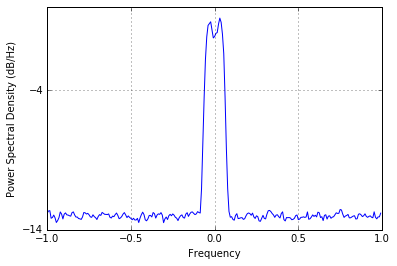

In [3]:

BR=33e9
analog_rate=16*BR
fix_adc_rate1=5/3*BR
import random
N_data = int(10*1024)

def gen_data_rx(alfa=0.1):
    data = np.array([complex(2*random.randint(0,1)-1,2*random.randint(0,1)-1) for i in xrange(N_data)])
    data_zeros = np.zeros((N_data*16,1),dtype=complex).flatten()
    data_zeros[1::16] = data    
    rcos_filter = rrcosfilter(64,alfa,1/BR,16*BR)[1]
    power_of_filter = np.sqrt(np.sum([ np.square(j) for j in rcos_filter]))
    rcos_filter = rcos_filter/power_of_filter
    data_interp = np.convolve(rcos_filter, data_zeros,'same')
    return data_interp

def gen_noise(SNRdb=13):
    sigma_noise = 1/np.sqrt(10**(SNRdb/10.0))
    noise = np.array([complex(np.random.normal(scale=sigma_noise),np.random.normal(scale=sigma_noise)) for i in xrange(N_data*16)])
    return noise
    
Signal = gen_data_rx(0.1)
Noise=gen_noise()
#pl.psd(Signal)
#pl.psd(Noise)
pl.psd(np.add(Signal,Noise))
pl.show()

In [434]:
rcos_filter=rrcosfilter(64,0.1,1/BR,16*BR)[1]
print np.array([complex(2*random.randint(0,1)-1,2*random.randint(0,1)-1) for i in xrange(N_data)])

[ 1.+1.j -1.-1.j  1.-1.j ...,  1.-1.j  1.-1.j -1.-1.j]


## Genero Filtro AFE

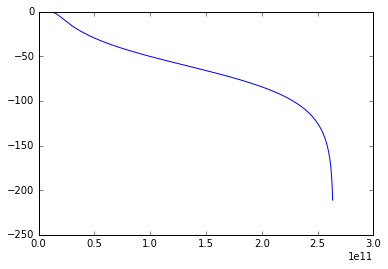

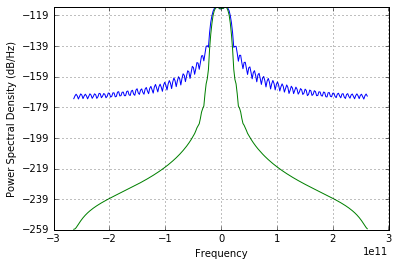

In [4]:
b, a = scipy.signal.butter(3, (BR/2)/(analog_rate/2), 'low', analog=False)
w, h = scipy.signal.freqz(b, a,)
pl.plot(w*analog_rate/(2*np.pi), 20 * np.log10(abs(h)))
pl.figure()
filtered = scipy.signal.filtfilt(b, a, Signal)
pl.psd(Signal,Fs=analog_rate)
pl.psd(filtered,Fs=analog_rate)
pl.show()

## Genero funciones de procesamientro

In [5]:
def offset_analog(offset,data):
    complex_lo_tx=[ complex(np.cos(2*np.pi*offset*phi/analog_rate),np.sin(2*np.pi*offset*phi/analog_rate)) for phi in xrange(len(data)) ] # 1GHz
    return np.multiply(complex_lo_tx,data)

In [6]:
def offset_digital(offset,data):
    complex_lo_rx=[ complex(np.cos(2*np.pi*offset*phi/fix_adc_rate1),-np.sin(2*np.pi*offset*phi/fix_adc_rate1)) for phi in xrange(len(data)) ] # 1GHz
    return np.multiply(complex_lo_rx,data)

## Inicio transmision

### Sobremuestreo las 2 muestras por simbolo a 16 muestras por simbolo con interpolacion

### Agredo ruido y filtro con AFE

### Pongo offset y filtro con AFE

## Sampling

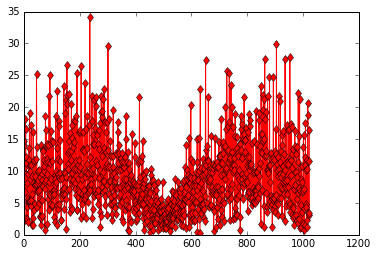

In [8]:
from fractions import Fraction
a=Fraction(fix_adc_rate1/analog_rate)
sampled_data=scipy.signal.resample(filtered,int(float(len(Signal))*a))
pl.plot(abs(np.fft.fft(sampled_data,1024)),'-dr')
pl.show()

In [9]:
def calc_dpm_error(data,mask_width=0.2,mask_pos=0.6):
    N0=int(round(64/2*mask_pos)-round(mask_width*64/2))
    N1=int(round(64/2*mask_pos)+round(mask_width*64/2))
    N2= 64-N1
    N3= 64-N0
    spectrum = np.fft.fft(data,64)

    error_signal=(np.sum(np.square(np.abs(spectrum[N0:N1+1]))) - np.sum(np.square(np.abs(spectrum[N2:N3+1]))))
    return error_signal

# Loop DPM  

In [12]:
freqs = np.linspace(0,5,6)

rolloffs = [0.1,0.2,0.5]
afe_fc = np.linspace(18e9,35e9,3)
SamplingFraction1 = Fraction(5,3)
SamplingFraction2 = Fraction(4,3)

fix_adc_rate1 = BR*SamplingFraction1
correction_factors=[.50,.89,.96]
#correction_factors=[1.,1.,1.]

fix_adc_rate2 = BR*SamplingFraction2
frac_rate1 = Fraction(fix_adc_rate1/analog_rate)
frac_rate2 = Fraction(fix_adc_rate2/fix_adc_rate1)

stats = {}
system=[1,2,3]
N_data = int(18*1024)
for n in system:
    stats[n]={}
    #fig = pl.figure()
    for k in enumerate(afe_fc):
        #pl.figure()
        stats[n][k[1]]={}
        b, a = scipy.signal.butter(3, 2*k[1]/analog_rate, 'low', analog=False)
        for i in rolloffs:
            
            
            stats[n][k[1]][i] = []
            variances = []
            
            
            rx_rcos_filter = rrcosfilter(64,i,1/BR,fix_adc_rate1)[1]
            power_of_filter = np.sqrt(np.sum([ np.square(j) for j in rx_rcos_filter]))
            rx_rcos_filter = rx_rcos_filter/power_of_filter
            for j in freqs:
                Signal = gen_data_rx(i)
                noisy_signal = np.add(Signal,gen_noise(8))#np.add(noise,f2(xnew))
                correlations = []
                offset_signal = offset_analog(j*1e9,noisy_signal)
                filtered = scipy.signal.filtfilt(b, a, offset_signal)
                sampled_data = scipy.signal.resample(filtered,int(float(len(Signal))*frac_rate1))
                #stats[n][k][i]=[]
                error=[]
                accum=0
                instant_error=0
                for l in range(len(sampled_data)/64):
                    if (l<80):
                        gain=1396400
                    else:
                        gain=256400
                    
                    accum=accum+instant_error*gain
                    parallel_samples=sampled_data[l*64:(l+1)*64]
                    rotated_parallel_samples = offset_digital(accum*correction_factors[k[0]],parallel_samples)
                    if (n == 1):
                        filtered2 = np.convolve(rx_rcos_filter, rotated_parallel_samples,'same')
                        sampled_data2 = scipy.signal.resample(filtered2,int(float(len(filtered2))*frac_rate2))
                        instant_error=calc_dpm_error(list(sampled_data2),mask_pos=1/SamplingFraction2)
                        
                    elif ( n == 2):
                        instant_error=calc_dpm_error(list(rotated_parallel_samples),mask_pos=1/SamplingFraction1)
                        
                    else:
                        filtered2 = np.convolve(rx_rcos_filter, rotated_parallel_samples,'same')
                        instant_error=calc_dpm_error(list(filtered2),mask_pos=1/SamplingFraction1)
                        
                        
                    error.append(accum)
                #pl.plot(error,label=str(j)+str(n)+str(i))
                stats[n][k[1]][i].append(error)


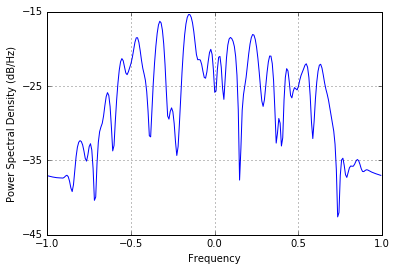

In [13]:
pl.psd(filtered2)
pl.show()

In [387]:
fix_adc_rate

55000000000.0

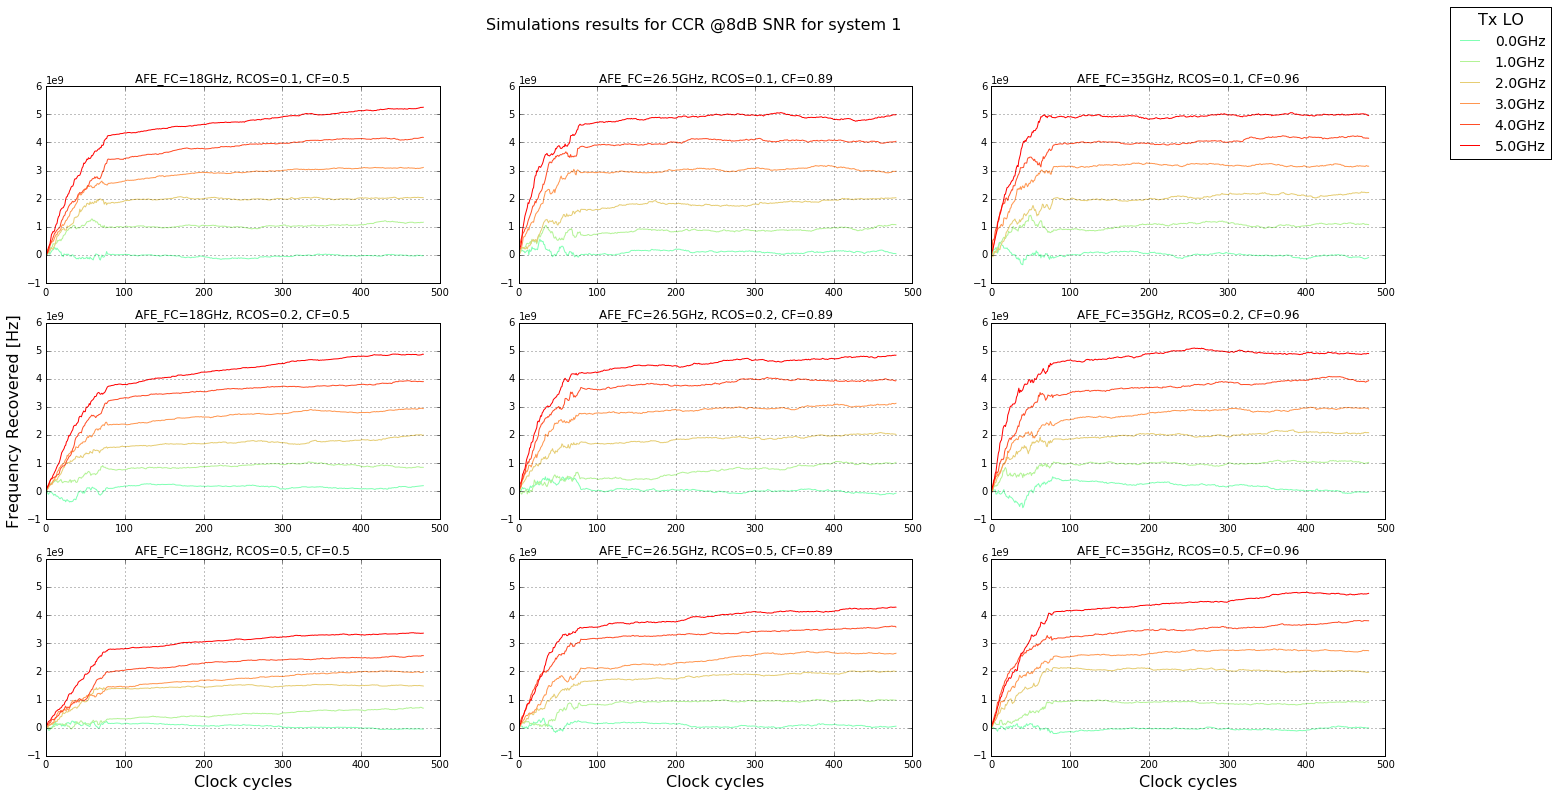

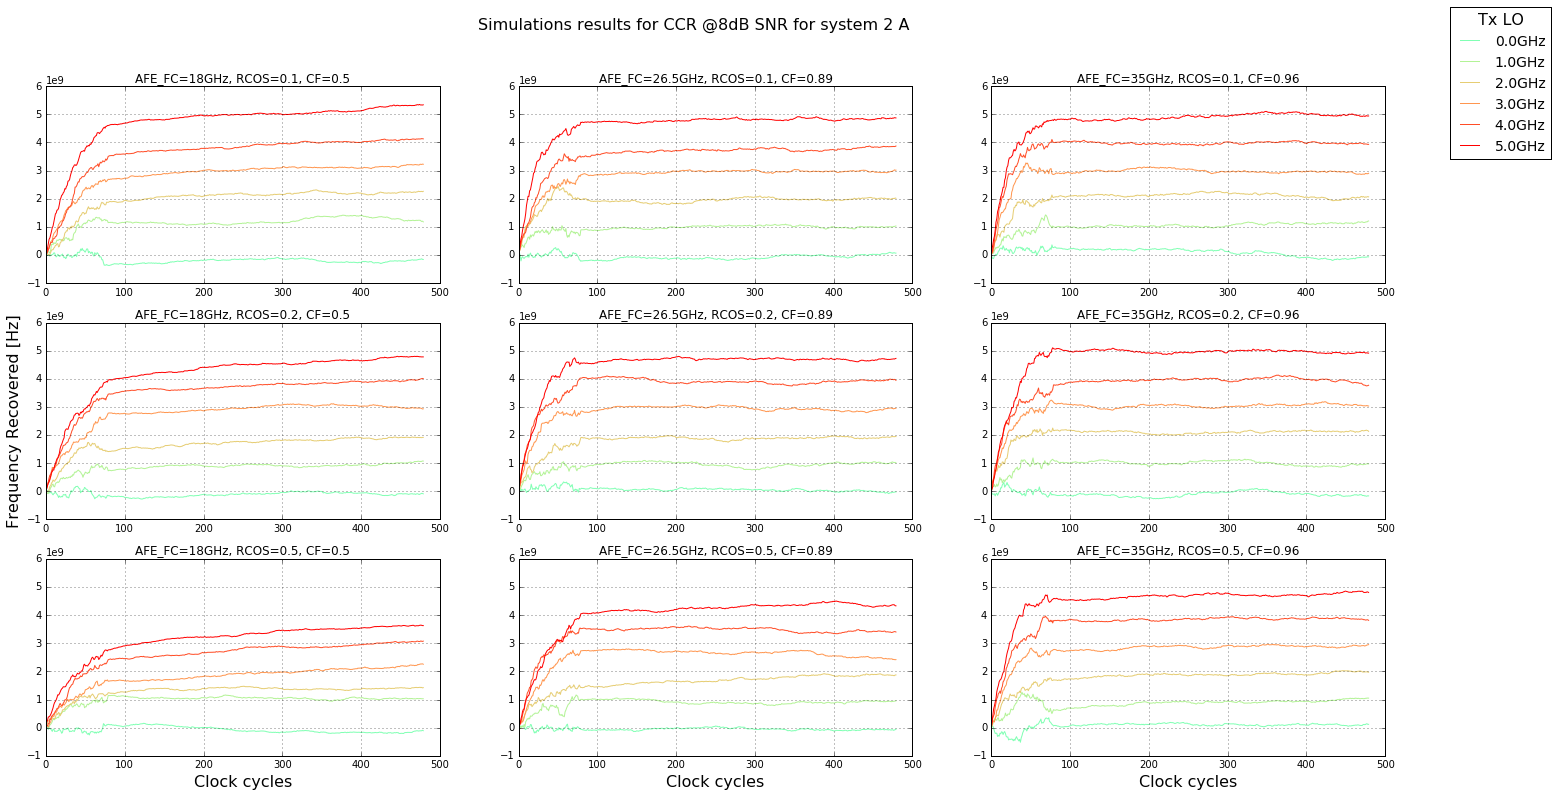

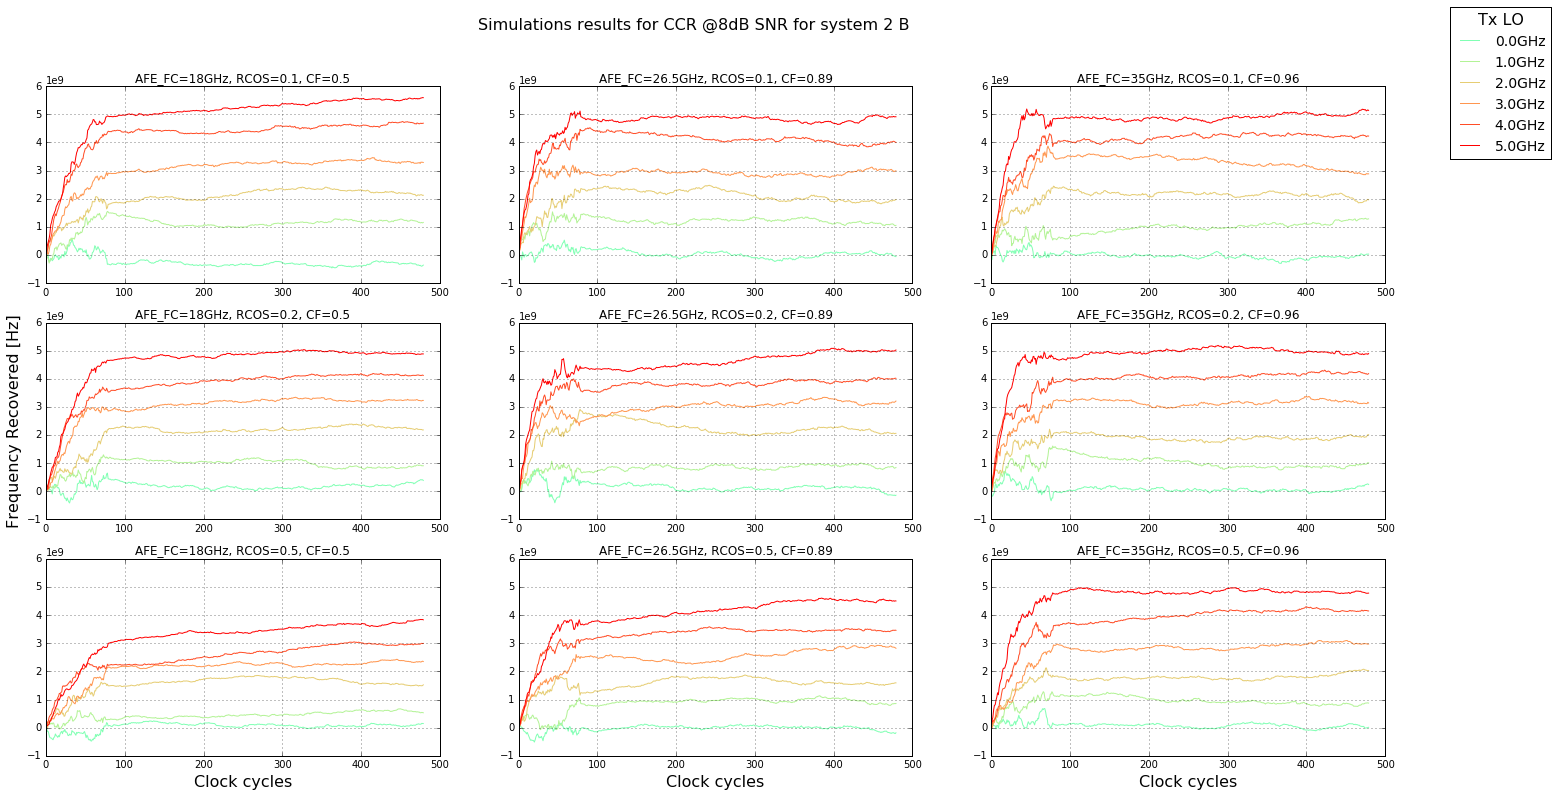

In [14]:
# Two subplots, the axes array is 1-d
#pl.figure( figsize=(2.5*8, 2.5*6), dpi=80, facecolor='w', edgecolor='k')
import itertools
system=range(1,4)

sys_labels=["1","2 A", "2 B"]  
for g in system:
    
    f, axarr = pl.subplots(3,3, sharey=False,figsize=(3*8, 2*6), dpi=80, facecolor='w', edgecolor='k')
    f.suptitle('Simulations results for CCR @8dB SNR for system {0}'.format(sys_labels[g-1]),fontsize=16)
    axarr[1][0].set_ylabel('Frequency Recovered [Hz]',fontsize=16)
    axarr[2][0].set_xlabel('Clock cycles',fontsize=16)
    axarr[2][1].set_xlabel('Clock cycles',fontsize=16)
    axarr[2][2].set_xlabel('Clock cycles',fontsize=16)
        
    for n in enumerate(afe_fc):
         
        for m in ([15]):
            for h in enumerate(rolloffs):
                axarr[h[0]][n[0]].grid()
                energy_line=stats[g][n[1]][h[1]]
                for l in enumerate(freqs):

                    axarr[h[0]][n[0]].plot(energy_line[l[0]],color=pl.cm.rainbow((l[0]+5)/10.0),label='{0}GHz'.format(l[1]))
                    axarr[h[0]][n[0]].set_title('AFE_FC={0:g}GHz, RCOS={1}, CF={2}'.format(n[1]/1e9,h[1],correction_factors[n[0]]))
                    axarr[h[0]][n[0]].set_ylim([-1e9, 6e9])
                
                # Make the y-axis label and tick labels match the line color.
        handles, labels = axarr[h[0]][n[0]].get_legend_handles_labels()
        
        legend=f.legend(handles,labels,loc='upper right',fontsize=14)
        legend.set_title('Tx LO')
        legend.get_title().set_fontsize('16')
        pl.savefig('results_system_{0}_long_run_pos_freq_cf.eps'.format(g))
pl.show()



In [191]:
range(1,4)

[1, 2, 3]

# Figura de repeticions con Histogramas

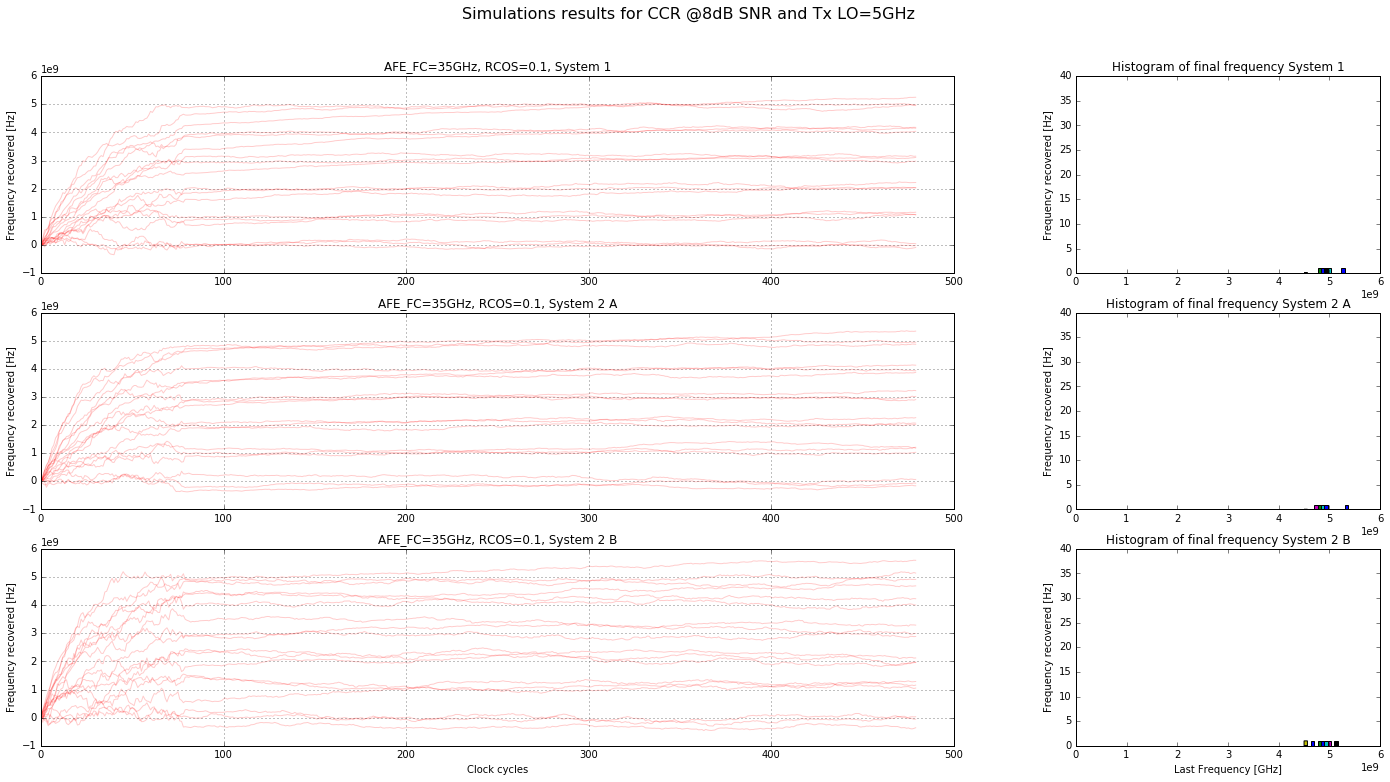

In [15]:
# Two subplots, the axes array is 1-d
#pl.figure( figsize=(2.5*8, 2.5*6), dpi=80, facecolor='w', edgecolor='k')
import itertools
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(3, 2,
                       width_ratios=[3,1],
                       height_ratios=[1,1,1])


system=range(1,4)
f = pl.figure(figsize=(3*8, 2*6), dpi=80, facecolor='w', edgecolor='k')

f.suptitle('Simulations results for CCR @8dB SNR and Tx LO=5GHz',fontsize=16)
sys_labels=["1","2 A", "2 B"]  
for g in system:
    
         
    for n in enumerate(afe_fc):
        ax= pl.subplot(gs[2*(g-1)],)
        ax.grid()
        for m in ([15]):
            for h in enumerate(rolloffs):
                
                energy_line=stats[g][n[1]][h[1]]
                last_freq=[]
                for l in enumerate(freqs):
                                        
                    last_freq.extend(energy_line[l[0]][-1:])
                    ax.plot(energy_line[l[0]],alpha=0.2,color='r',label='{0}GHz'.format(l[1]))
                    ax.set_title('AFE_FC={0:g}GHz, RCOS={1}, System {2}'.format(n[1]/1e9,h[1],sys_labels[g-1]))
                    
                    ax.set_ylabel('Frequency recovered [Hz]')
                    #axarr[h[0]][n[0]].set_ylim([-6e9, 1e9])
                #ax.set_rasterized(True)

                ax= pl.subplot(gs[2*(g-1)+1])
                ax.set_title('Histogram of final frequency System {0}'.format(sys_labels[g-1]))
                
                ax.hist(last_freq,15,range=[4.5e9,5.5e9],)
                ax.set_ylim([0,40])
                # Make the y-axis label and tick labels match the line color.
        

ax=pl.subplot(gs[4])
ax.set_xlabel('Clock cycles')

ax=pl.subplot(gs[5])
ax.set_xlabel('Last Frequency [GHz]')
pl.savefig('result_repetition_systems.eps')
pl.show()



In [16]:
stats[g[1]]

TypeError: 'int' object has no attribute '__getitem__'

KeyError: 13

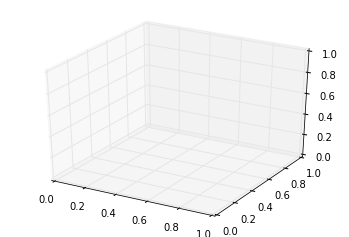

In [17]:

import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
teapot = stats[13][afe_fc[1]][0.1]
for i,j in teapot.items():
    ax.plot([0,0],[i,i],zs=[j[0],j[0]])
pl.show()
Axes3D.plot()

In [ ]:
from scipy.signal.resample

In [ ]:
from scipy.signal.decimate